In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 27.4MB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_width = 128
input_height = 128
input_channel = 3
img_shape = [input_width, input_height, input_channel]
interpolation_method = "bilinear"
num_classes = 5

train_path = '/content/drive/MyDrive/dataset_split_512_ACGMN/train'
valid_path = '/content/drive/MyDrive/dataset_split_512_ACGMN/valid'
test_path = '/content/drive/MyDrive/dataset_split_512_ACGMN/test'

train_dategen = ImageDataGenerator()
train_generator = train_dategen.flow_from_directory(
    train_path,
    target_size=(input_height, input_width),
    batch_size=2405,
    shuffle = True,
    interpolation = interpolation_method,
    class_mode = 'sparse')

val_dategen = ImageDataGenerator()
val_generator = val_dategen.flow_from_directory(
    valid_path,
    target_size=(input_height, input_width),
    batch_size=348,
    shuffle = False,
    interpolation = interpolation_method,
    class_mode = 'sparse')

test_dategen = ImageDataGenerator()
test_generator = test_dategen.flow_from_directory(
    test_path,
    target_size=(input_height, input_width),
    batch_size=686,
    shuffle = False,
    interpolation = interpolation_method,
    class_mode = 'sparse')

x_train, y_train = train_generator[0]
x_test, y_test = test_generator[0]
x_val, y_val = val_generator[0]


Found 2405 images belonging to 5 classes.
Found 348 images belonging to 5 classes.
Found 686 images belonging to 5 classes.


In [6]:
num_classes = 5
input_shape = (128, 128, 3)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (2405, 128, 128, 3) - y_train shape: (2405,)
x_test shape: (686, 128, 128, 3) - y_test shape: (686,)


In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 250
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        # layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


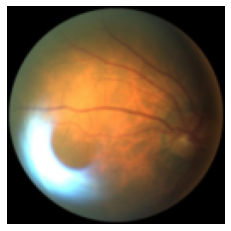

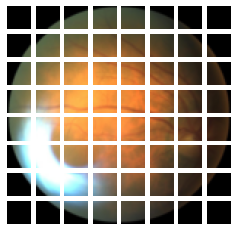

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/250
38/38 [==============================] - 22s 177ms/step - loss: 2.9431 - accuracy: 0.5969 - top-2-accuracy: 0.7313 - val_loss: 1.0499 - val_accuracy: 0.6472 - val_top-2-accuracy: 0.8338

Epoch 00001: val_accuracy improved from -inf to 0.64723, saving model to /content/transformer_patch8.h5
Epoch 2/250
38/38 [==============================] - 5s 138ms/step - loss: 1.0960 - accuracy: 0.7133 - top-2-accuracy: 0.8226 - val_loss: 0.9055 - val_accuracy: 0.7624 - val_top-2-accuracy: 0.8499

Epoch 00002: val_accuracy improved from 0.64723 to 0.76239, saving model to /content/transformer_patch8.h5
Epoch 3/250
38/38 [==============================] - 5s 138ms/step - loss: 0.9984 - accuracy: 0.7403 - top-2-accuracy: 0.8382 - val_loss: 0.9596 - val_accuracy: 0.7638 - val_top-2-accuracy: 0.8571

Epoch 00003: val_accuracy improved from 0.76239 to 0.76385, saving model to /content/transformer_patch8.h5
Epoch 4/250
38/38 [==============================] - 5s 137ms/step - loss: 0.9523 - acc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[  0   0   0   1  42]
 [  0  18   0   1  25]
 [  0   2   1   0  36]
 [  0   2   0  26   9]
 [  0   5   0   2 516]]


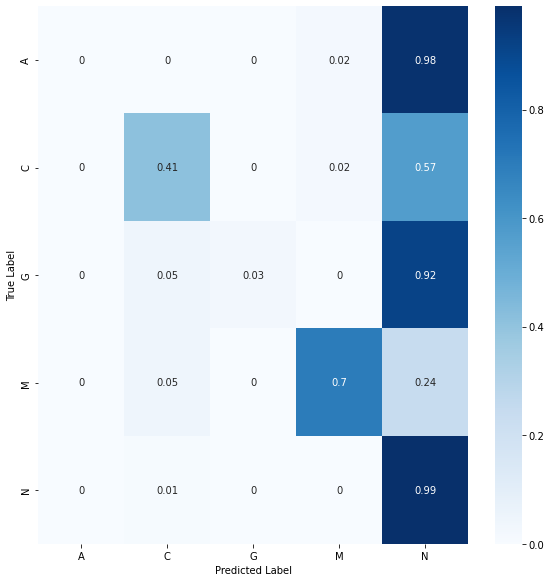

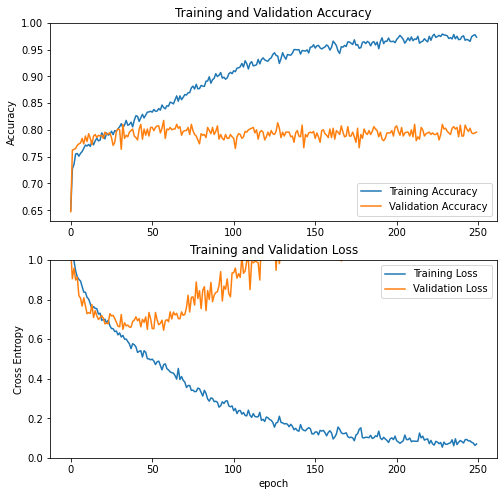

In [14]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import top_k_accuracy_score
import seaborn as sns

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "transformer_patch16.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose = 2
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_test, y_test),
        callbacks=[checkpoint_callback],
    )



    model.load_weights(checkpoint_filepath)
    _, accuracy, top_2_accuracy = model.evaluate(x_test, y_test)

    print("--Evaluate--")
    # model = model.load_weights(checkpoint_filepath)
    scores = model.evaluate(test_generator)
    print ("%s: %.2f%%" %('Test top-1 accuracy', scores[1]*100))

    Y_pred = model.predict_generator(test_generator)
    # print ("%s: %.2f%%" %('Test top-2 accuracy', top_k_accuracy_score(test_generator.classes, Y_pred, k=2)*100))

    y_pred = np.argmax(Y_pred, axis=1)
    target_names = test_generator.class_indices.keys()

    print('Confusion Matrix')
    con_mat = confusion_matrix(test_generator.classes, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    print(con_mat)

    con_mat_df = pd.DataFrame(con_mat_norm,
                            index = target_names,
                            columns = target_names)
    figure = plt.figure(figsize = (8,8))
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel('Predicted Label')
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)